In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import SGD, Adam
from tqdm import tqdm
import os

from utils import Encoder, Decoder, awgn, ser_mqam_awgn  # Import custom utils

In [31]:
CONFIG = {
    "M": 16,  # Number of constellation points
    "flag_train_model": True,  # Flag to control training
    "training_snr": 20,  # Training SNR (dB)
    "checkpoint_file": "./models/ae_siso_awgn_16qam.pth",
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [32]:
encoder = Encoder([CONFIG["M"], 10, 10, 2]).to(device)
decoder = Decoder([2, 20, 20, CONFIG["M"]]).to(device)

Resuming training from epoch 2009


training process: 100%|██████████| 1000/1000 [00:25<00:00, 39.31it/s]


Training complete


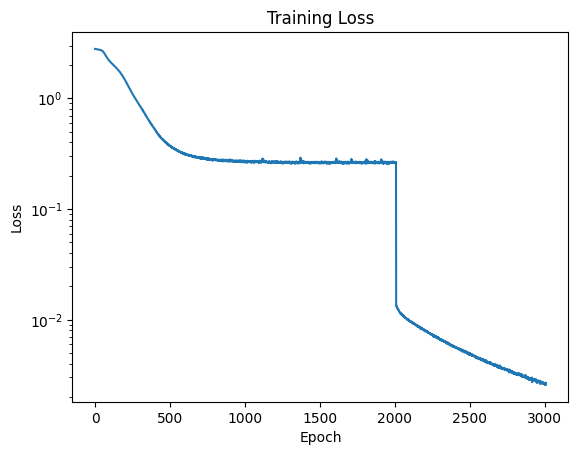

In [33]:
def save_model(encoder, decoder, loss):
    torch.save(
        {
            "Encoder": encoder.state_dict(),
            "Decoder": decoder.state_dict(),
            "loss": loss,
        },
        CONFIG["checkpoint_file"],
    )


def train_model(encoder, decoder, optimizer, num_epochs, loss_hist, device):
    criterion = nn.NLLLoss()  # negative log likelihood loss
    try:
        for epoch in tqdm(range(num_epochs), desc="training process"):
            messages = torch.randint(0, CONFIG["M"], size=(64000,), device=device)
            one_hot = F.one_hot(messages, CONFIG["M"]).float()
            tx = encoder(one_hot)
            rx = awgn(tx, CONFIG["training_snr"])
            y_pred = decoder(rx)

            loss = criterion(y_pred, messages)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())

        save_model(encoder, decoder, loss_hist)
        print("Training complete")

        # Plot the loss
        plt.semilogy(loss_hist)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.show()

    except KeyboardInterrupt:
        save_model(encoder, decoder, loss_hist)
        print("Training interrupted")


if CONFIG["flag_train_model"]:
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = Adam(parameters, lr=0.0001)
    num_epochs = int(1e3)
    # check if there is a checkpoint to resume training
    if os.path.exists(CONFIG["checkpoint_file"]):
        checkpoint = torch.load(CONFIG["checkpoint_file"])
        encoder.load_state_dict(checkpoint["Encoder"])
        decoder.load_state_dict(checkpoint["Decoder"])
        loss_hist = checkpoint["loss"]  # Use a different variable name
        print(f"Resuming training from epoch {len(loss_hist)}")
    else:
        loss_hist = []  # Initialize the loss list
        print("Training from scratch")
    train_model(encoder, decoder, optimizer, num_epochs, loss_hist, device)
else:
    # check if there is a checkpoint to load the model
    if os.path.exists(CONFIG["checkpoint_file"]):
        checkpoint = torch.load(CONFIG["checkpoint_file"])
        encoder.load_state_dict(checkpoint["Encoder"])
        decoder.load_state_dict(checkpoint["Decoder"])
        print("Model loaded")
    else:
        print(
            "Model not found, please set flag_train_model to True and train the model"
        )
        exit(1)

In [34]:
SNR_dB = np.arange(0, 22, 2)
SER = np.array([])

iteration = tqdm(range(len(SNR_dB)), desc="simulation process")
for iterator in iteration:
    snr = SNR_dB[iterator]
    num_mess = 6400  # number of messages to test
    minErr = 1  # minimum number of errors
    minSym = 1e6  # minimum number of symbols
    totSym = 0  # total number of symbols
    totErr = 0  # total number of errors
    while totErr < minErr or totSym < minSym:
        messages = torch.randint(0, CONFIG["M"], size=(num_mess,)).to(device)
        one_hot = F.one_hot(messages).float()
        tx = encoder(one_hot)
        rx = awgn(tx, snr)
        rx_constant = (
            rx.clone().detach().requires_grad_(False)
        )  # no gradients in the channel model

        y_pred = decoder(rx_constant)

        m_hat = torch.argmax(y_pred, -1)

        err = torch.sum(torch.not_equal(messages, m_hat)).to("cpu").detach().numpy()

        totErr += err
        totSym += num_mess
    SER = np.append(SER, totErr / totSym)

simulation process: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]


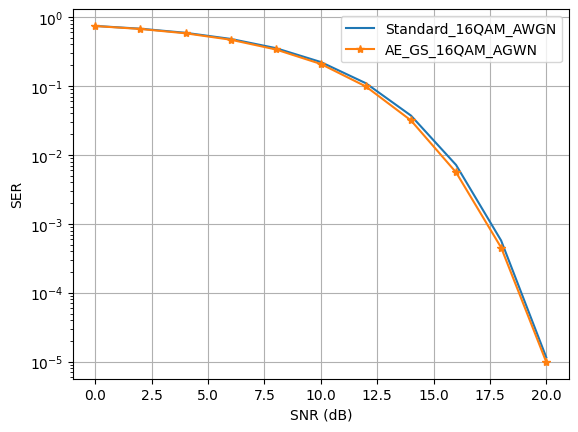

In [35]:
SER_theory = ser_mqam_awgn(CONFIG["M"], SNR_dB)
# plot the SER-SNR curve
plt.figure()
plt.xlabel("SNR (dB)")
plt.ylabel("SER")
plt.semilogy(SNR_dB, SER_theory, label="Standard_16QAM_AWGN")
plt.semilogy(SNR_dB, SER, "-*", label="AE_GS_{}QAM_AGWN".format(CONFIG["M"]))
plt.legend()
plt.grid(True)

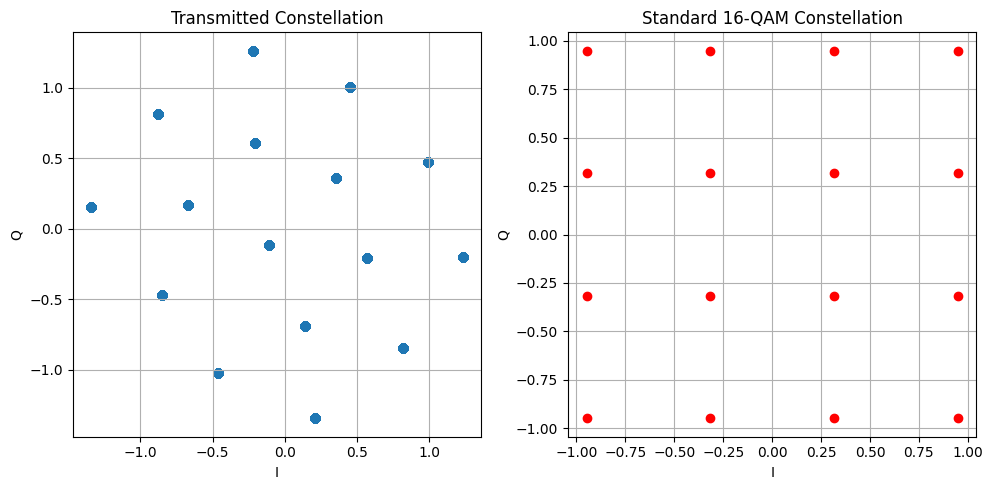

In [36]:
# Generate transmitted symbols using the encoder
num_mess = 6400  # number of messages to test
messages = torch.randint(0, CONFIG["M"], size=(num_mess,)).to(device)
one_hot = F.one_hot(messages).float()
tx = encoder(one_hot)
tx = tx.to("cpu").detach().numpy()

# Define the coordinates for 16-QAM constellation points
points_I = np.array([1, 1, 1, 1, -1, -1, -1, -1, 3, 3, 3, 3, -3, -3, -3, -3]) / np.sqrt(
    10
)
points_Q = np.array([3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3]) / np.sqrt(
    10
)

# Plot both constellations
plt.figure(figsize=(10, 5))

# Plot transmitted symbols
plt.subplot(1, 2, 1)
plt.scatter(tx[:, 0], tx[:, 1])
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Transmitted Constellation")
plt.grid(True)

# Plot standard 16-QAM constellation
plt.subplot(1, 2, 2)
plt.scatter(points_I, points_Q, c="r")
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Standard 16-QAM Constellation")
plt.grid(True)

plt.tight_layout()
plt.show()